# Week 40 - Assignment 2
###### -------- use "Week_40_lecture - iris_RF_rework" as reference --------

Part 1: Data Acquisition and Preprocessing
- Import wine quality CSV file
- Convert to dataframe and map values
- Clean dataframe

Part 2: Model Building and Tuning
- Create Random Forest (RF)
- Evaluate attributes information gain

Part 3: Prediction, Evaluation, and Analysis

In [1]:
# -------- LIBRARIES --------

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

# -------- DATASET --------

## Read dataset CSV file
wine_csv = pd.read_csv(
    r"C:\Users\natha\UiS - MOD550\mod550-2025\MOD550-AUREF.ROSTAMIAN-ASSIGNMENTS\wine_quality.csv"
    )
### Convert to dataframe
wine_df = pd.DataFrame(wine_csv)
### Print number of rows and columns
print(f"Dataset column number: {wine_df.columns.size}")
print(f"Dataset row number: {wine_df.index.size}")
### Print column names
print(wine_df.columns)
### Print wine types
print(wine_df['type'].value_counts())
### Print wine quality values
print(wine_df['quality'].value_counts())
### Print first 5 rows
print(wine_df.head())


Dataset column number: 14
Dataset row number: 6497
Index(['Unnamed: 0', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality', 'type'],
      dtype='object')
type
white    4898
red      1599
Name: count, dtype: int64
quality
Not bad, second glass    2836
Meh, table wine          2138
Nice, dinner-worthy      1079
Ouch, my palate           216
Chef's kiss               193
Worst taste wine           30
Halleluya                   5
Name: count, dtype: int64
   Unnamed: 0  fixed acidity  volatile acidity  citric acid  residual sugar  \
0        6496            6.1              0.26         0.25             2.9   
1        6495            6.8              0.26         0.34            15.1   
2        6467           11.6              0.58         0.66             2.2   
3        6468           10.4              0.61         0.49             2.1

In [2]:
# -------- DATA CLEANING --------

## Turn empty strings into NaN values
wine_df = wine_df.replace(r'^\s*$', np.nan, regex=True)

## drop unnamed column
wine_df = wine_df.drop(columns=["Unnamed: 0"])


In [3]:
# -------- TRAIN/TEST DATA SPLITTING --------

## Assign random constant for reproducibility
RSEED = 44
np.random.seed(RSEED)

## Define target
x = pd.get_dummies(wine_df.drop(columns=["quality"]), drop_first=True)
y = wine_df["quality"]

## Train/test split (stratified to preserve class ratios, 25% test size)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=RSEED, stratify=y)

print(f"Train size: {len(x_train)}")
print(f"Test size: {len(x_test)}")
print(f"Training set %: {len(x_train) / (len(x_train) + len(x_test)) * 100:.2f}")


Train size: 4872
Test size: 1625
Training set %: 74.99


In [4]:
# -------- RANDOM FOREST --------

## Model
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=RSEED,
    n_jobs=-1
)

## Fit and prediction
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

## Accuracy of model between actual and predicted values
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.3f}")

## Cross-validated accuracy (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
cv_scores = cross_val_score(clf, x, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"\n5-fold CV accuracy: mean={cv_scores.mean():.3f}, std={cv_scores.std():.3f}")

## Confusion matrix with labels
class_names = sorted(np.unique(np.concatenate([y_test, y_pred])))  # Ensure alignment
cm = confusion_matrix(y_test, y_pred, labels=class_names)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\nConfusion matrix:")
print(cm_df)



Accuracy: 0.678

5-fold CV accuracy: mean=0.691, std=0.009

Confusion matrix:
                       Chef's kiss  Halleluya  Meh, table wine  \
Chef's kiss                     15          0                2   
Halleluya                        0          0                0   
Meh, table wine                  0          0              395   
Nice, dinner-worthy              0          0               12   
Not bad, second glass            4          0              104   
Ouch, my palate                  0          0               29   
Worst taste wine                 0          0                5   

                       Nice, dinner-worthy  Not bad, second glass  \
Chef's kiss                             14                     17   
Halleluya                                1                      0   
Meh, table wine                          3                    136   
Nice, dinner-worthy                    129                    129   
Not bad, second glass                   42     

In [5]:
# -------- ATTRIBUTES WEIGHT --------

## Feature importance with original dataset (sorted)
fi = pd.Series(clf.feature_importances_, index=x.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(fi)



Feature importances:
alcohol                 0.126613
density                 0.100944
volatile acidity        0.098022
total sulfur dioxide    0.090405
free sulfur dioxide     0.086513
sulphates               0.086093
residual sugar          0.085352
chlorides               0.084034
pH                      0.082495
citric acid             0.081081
fixed acidity           0.075106
type_white              0.003341
dtype: float64


In [6]:
# -------- MODEL TRAINING WITH SELECTED FEATURES --------

## Retrain model with selected features
"""
Retrain model with following features (most meaningful features to human):
    Alcohol, Density, Volatile acidity, Citric acid, Total sulfur dioxide, Sulphates, Residual sugar, pH
"""
selected_features = [
    "alcohol",
    "density",
    "volatile acidity",
    "citric acid",
    "total sulfur dioxide",
    "sulphates",
    "residual sugar",
    "pH"
]

## Redefine variables for selected features
x_train_sel = x_train[selected_features]
x_test_sel = x_test[selected_features]

## Fit model for selected features
clf.fit(x_train_sel, y_train)
y_pred_sel = clf.predict(x_test_sel)

## Accuracy of new model
acc_sel = accuracy_score(y_test, y_pred_sel)
print(f"\nAccuracy with selected features: {acc_sel:.3f}")

## Cross-validated accuracy of new model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
cv_scores = cross_val_score(clf, x, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"\n5-fold CV accuracy: mean={cv_scores.mean():.3f}, std={cv_scores.std():.3f}")

## Feature importance with selected features
fi_sel = pd.Series(
    clf.feature_importances_,
    index=selected_features
).sort_values(ascending=False)
print("\nFeature importances:")
print(fi_sel)



Accuracy with selected features: 0.675

5-fold CV accuracy: mean=0.691, std=0.009

Feature importances:
alcohol                 0.150892
density                 0.139486
volatile acidity        0.128731
total sulfur dioxide    0.124372
residual sugar          0.118607
sulphates               0.115121
pH                      0.113305
citric acid             0.109486
dtype: float64


In [7]:
# -------- LOGISTIC REGRESSION --------
"""
Logistic Regression basics and implementation
Reference 1: https://www.w3schools.com/python/python_ml_logistic_regression.asp
Reference 2: https://www.geeksforgeeks.org/machine-learning/ml-logistic-regression-using-python/
Youtube video: https://www.youtube.com/watch?v=GAiMnImkIZM&t=910s
"""
## Import missing libraries for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

## Refresh dataset
wine_dataset = pd.DataFrame(wine_csv)

## Turning quality into binary classification for logistic regression
print(wine_dataset["quality"].unique())
wine_dataset["quality"] = pd.to_numeric(wine_df["quality"], errors="coerce")
print(wine_dataset["quality"].head())

## Define binary target variable
"""
0 = "Worst taste wine", "Ouch, my palate", "Meh, table wine"
1 = "Not bad, second glass", "Nice, dinner-worthy", "Chef's kiss", "Halleluya"
"""
label_map = {
    "Worst taste wine": 0,
    "Ouch, my palate": 0,
    "Meh, table wine": 0,
    "Not bad, second glass": 1,
    "Nice, dinner-worthy": 1,
    "Chef's kiss": 1,
    "Halleluya": 1
}

y_binary = wine_df["quality"].map(label_map)
print(y_binary.value_counts())

## Train-test split for binary classification (20% test size)
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(
    x,
    y_binary,
    test_size = 0.20,
    random_state = RSEED,
    stratify=y_binary
)

## Standardize features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train_bin)
X_test_scaled = scaler.transform(x_test_bin)

## Initialize logistic regression model
Lr = LogisticRegression()

## Train the model
Lr.fit(X_train_scaled, y_train_bin)

## Model predictions
y_pred_lr = Lr.predict(X_test_scaled)
y_prob_lr = Lr.predict_proba(X_test_scaled)[:, 1]

# -------- METRICS & EVALUATION --------

accuracy_lr = accuracy_score(y_test_bin, y_pred_lr)
print("\nLogistic Regression Accuracy: {:.2f}%".format(accuracy_lr * 100))

print("\nConfusion Matrix (LogReg):")
print(confusion_matrix(y_test_bin, y_pred_lr))

print("\nClassification Report (LogReg):")
print(classification_report(y_test_bin, y_pred_lr, target_names=["Bad Wine", "Good Wine"]))


['Worst taste wine' 'Ouch, my palate' 'Meh, table wine'
 'Not bad, second glass' 'Nice, dinner-worthy' "Chef's kiss" 'Halleluya']
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: quality, dtype: float64
quality
1    4113
0    2384
Name: count, dtype: int64

Logistic Regression Accuracy: 75.62%

Confusion Matrix (LogReg):
[[276 201]
 [116 707]]

Classification Report (LogReg):
              precision    recall  f1-score   support

    Bad Wine       0.70      0.58      0.64       477
   Good Wine       0.78      0.86      0.82       823

    accuracy                           0.76      1300
   macro avg       0.74      0.72      0.73      1300
weighted avg       0.75      0.76      0.75      1300



In [8]:
# -------- COEFFICIENTS & INTERPRETATION --------

## Coefficients represent log-odds contribution of each feature for each class
coef_df = pd.DataFrame(Lr.coef_, columns=x.columns, index=["Good Wine"])
print("\nLogistic Regression Coefficients (log-odds):")
print(coef_df)

## Convert coefficients to odds ratios for easier interpretation
odds_ratios = np.exp(coef_df)
print("\nLogistic Regression Odds Ratios:")
print(odds_ratios)



Logistic Regression Coefficients (log-odds):
           fixed acidity  volatile acidity  citric acid  residual sugar  \
Good Wine        0.09701         -0.776386    -0.075351        0.554026   

           chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Good Wine  -0.080911              0.22433             -0.324845 -0.367865   

                 pH  sulphates   alcohol  type_white  
Good Wine  0.111198   0.330183  0.941009   -0.262789  

Logistic Regression Odds Ratios:
           fixed acidity  volatile acidity  citric acid  residual sugar  \
Good Wine       1.101871          0.460066     0.927418        1.740246   

           chlorides  free sulfur dioxide  total sulfur dioxide  density  \
Good Wine   0.922276             1.251484              0.722639  0.69221   

                 pH  sulphates   alcohol  type_white  
Good Wine  1.117616   1.391223  2.562567    0.768904  


From the previous output, we can interpret the odds ratios as follows:
The higher positive the odds ratio, the more that feature increases the chances of a wine being classified as "Good Wine".
Alternatively, an negative odds ratio indicates that the feature decreases the chances of being classified as "Good Wine".

Therefore, this can be interpreted as weights of features, which would result with the following:

    1. alcohol

    2. residual sugar

    3. sulphates

    4. free sulfur dioxide

    5. pH


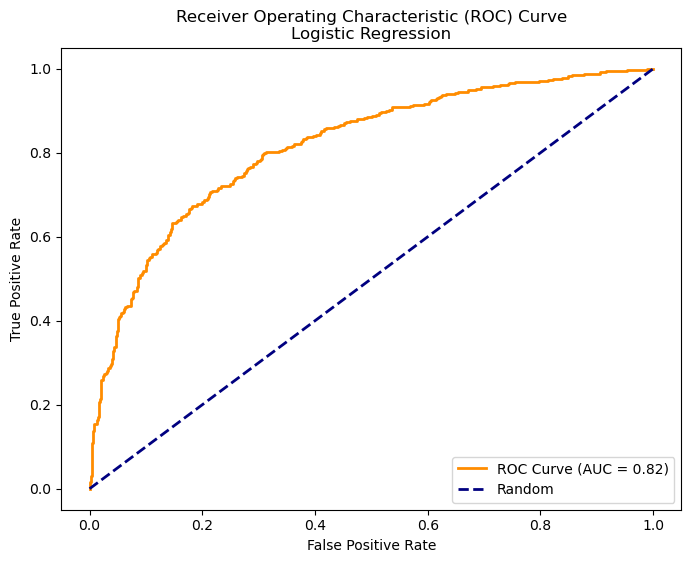

In [9]:
# -------- ROC CURVE --------
fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nLogistic Regression')
plt.legend(loc="lower right")
plt.show()
